https://github.com/pytorch/examples/blob/master/dcgan/main.py

In [53]:
from __future__ import print_function
import argparse
import os
import random
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', required=True, help='cifar10 | lsun | imagenet | folder | lfw | fake')
# parser.add_argument('--dataroot', required=True, help='path to dataset')
# parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
# parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
# parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
# parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
# parser.add_argument('--ngf', type=int, default=64)
# parser.add_argument('--ndf', type=int, default=64)
# parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
# parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
# parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
# parser.add_argument('--cuda', action='store_true', help='enables cuda')
# parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
# parser.add_argument('--netG', default='', help="path to netG (to continue training)")
# parser.add_argument('--netD', default='', help="path to netD (to continue training)")
# parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
# parser.add_argument('--manualSeed', type=int, help='manual seed')

# opt = parser.parse_args()
# print(opt)

In [12]:
# dataset = 
# dataroot = 

In [28]:
workers = 1
batchSize = 1
imageSize = 128
nz = 10         # 'size of the latent z vector'
ngf = 8         # dimension of the cube
ndf = 8         # dimension of the cube
niter = 25       # 'number of epochs to train for'
lr = 0.0002      # 'learning rate, default=0.0002'
beta1 = 0.5      # 'beta1 for adam. default=0.5'
cuda = False
ngpu = 0      
netG_arg = ""        # "path to netG (to continue training)"
netD_arg = ""        # "path to netD (to continue training)"
outf = "."       # 'folder to output images and model checkpoints'
manualSeed = 1   # 'manual seed'

In [29]:
try:
#     os.makedirs(opt.outf)
    os.makedirs(outf)
except OSError:
    pass

In [30]:
# if opt.manualSeed is None:
#     opt.manualSeed = random.randint(1, 10000)
# print("Random Seed: ", opt.manualSeed)
# random.seed(opt.manualSeed)
# torch.manual_seed(opt.manualSeed)

if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1


In [31]:
if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

In [32]:
# dataset

In [33]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

def get_samples(s_sample, nsamples, redshift, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-128
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, 
                                        sample_coords)
        
        sample_list.append(sample_coords)
    
    print("Sampling finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    datapath=''
    f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
    
    # getting the max of the whole cube
    #print(f.shape)
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
    #f.close()
    
    print("Getting max value finished.")
    
    counter = 0
    for c in sample_list:
        print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        # a = np.array(a)
        a = np.array(a) / max_cube
        sample_array.append(a)
    
        counter = counter + 1
        
    f=0
    return sample_array

In [34]:
class HydrogenDataset2(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, h5_file, root_dir, s_test, s_train,
                 s_sample, nsamples, redshift):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')["delta_HI"]
        self.h5_file = h5_file
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_train = s_train
        self.t_coords = define_test(self.s_test,
                                    self.s_train)
        self.s_sample = s_sample
        self.nsamples = nsamples
        self.redshift = redshift
        
        self.samples = get_samples(s_sample = self.s_sample,
                             nsamples = self.nsamples,
                             redshift = self.redshift,
                             test_coords = self.t_coords)

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
#         sample = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              redshift = self.redshift,
#                              test_coords = self.t_coords)
    
        sample = self.samples[idx].reshape((1,128,128,128))
        
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
        sample = sample/1e6

        return sample

In [35]:
class HydrogenDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, h5_file, root_dir):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')['sample32']
        self.h5_file = h5_file
        self.root_dir = root_dir

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
        return len(self.subcubes)

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
        #sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
        sample = self.subcubes[idx].reshape((1,128,128,128))

        return sample

In [36]:
# on prince
sampled_subcubes = HydrogenDataset2(h5_file="fields_z=1.0.hdf5",
                                    root_dir = "",
                                    s_test = 1024, 
                                    s_train = 128,
                                    s_sample = 128, 
                                    nsamples = 128, 
                                    redshift = "1.0")

FileNotFoundError: [Errno 2] No such file or directory: 'fields_z=1.0.hdf5'

In [37]:
# on local
sampled_subcubes = HydrogenDataset(h5_file="sample_32.h5",
                                    root_dir = "../data/")
dataset = sampled_subcubes

The file size is 268 MBs


In [38]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         #batch_size=opt.batchSize,
                                         batch_size = batchSize,
                                         shuffle=True, 
                                         #num_workers=int(opt.workers)
                                         num_workers=int(workers)
                                        )

In [39]:
# device = torch.device("cuda:0" if opt.cuda else "cpu")
# ngpu = int(opt.ngpu)
# nz = int(opt.nz)
# ngf = int(opt.ngf)
# ndf = int(opt.ndf)
# nc = 3

device = torch.device("cuda:0" if cuda else "cpu")
ngpu = int(ngpu)
nz = int(nz)
ngf = int(ngf)
ndf = int(ndf)

# number of channels
nc = 1

In [40]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [42]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose3d(in_channels=nz,
                               out_channels=ngf * 16,
                               kernel_size = 4,
                               stride = 1,
                               padding = 0, 
                               bias=False),
            nn.BatchNorm3d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose3d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose3d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose3d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        print("Forward Propagation of Generator")
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, 
                                               input, 
                                               range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [43]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
# if opt.netG != '':
#     netG.load_state_dict(torch.load(opt.netG))
if netG_arg != '':
    netG.load_state_dict(torch.load(netG_param))
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose3d(10, 128, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (7): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose3d(32, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (10): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose3d(16, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (13)

In [44]:
nc

1

In [45]:
ndf

8

In [46]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # nc = number of channels
            
            nn.Conv3d(in_channels=1, 
                      out_channels=8, 
                      kernel_size=(4,4,4), # == 4
                      stride = (2,2,2), # == 2
                      padding=(1,1,1), # == 1
                      bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv3d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv3d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv3d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, 
                                               input, 
                                               range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [47]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if netD_arg != '':
    netD.load_state_dict(torch.load(netD_arg))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv3d(1, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (9): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (12): BatchNorm3d(12

In [48]:
criterion = nn.BCELoss()

In [49]:
# fixed_noise = torch.randn(batchSize, 
#                           nz, 
#                           1, 
#                           1, 
#                           device=device)
real_label = 1
fake_label = 0

In [50]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), 
                        lr=lr, 
                        betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), 
                        lr=lr, 
                        betas=(beta1, 0.999))


 --------------------------------------
Epoch = 0 / 25
-------------------------------------- 

D_x = 0.9857088327407837
Forward Propagation of Generator
D_G_z1 = 0.00020005562691949308
errD = errD_real + errD_fake = tensor(0.0146, grad_fn=<ThAddBackward>)
[0/25][0/32] Loss_D: 0.0146 Loss_G: 8.6882 D(x): 0.9857 D(G(z)): 0.0002 / 0.0002
D_x = 0.9929515719413757
Forward Propagation of Generator
D_G_z1 = 0.0014645882183685899
errD = errD_real + errD_fake = tensor(0.0085, grad_fn=<ThAddBackward>)
[0/25][1/32] Loss_D: 0.0085 Loss_G: 6.6835 D(x): 0.9930 D(G(z)): 0.0015 / 0.0013
D_x = 0.9926428198814392
Forward Propagation of Generator
D_G_z1 = 0.006131414324045181
errD = errD_real + errD_fake = tensor(0.0135, grad_fn=<ThAddBackward>)
[0/25][2/32] Loss_D: 0.0135 Loss_G: 5.4817 D(x): 0.9926 D(G(z)): 0.0061 / 0.0042
D_x = 0.9934493899345398
Forward Propagation of Generator
D_G_z1 = 0.0006069376249797642
errD = errD_real + errD_fake = tensor(0.0072, grad_fn=<ThAddBackward>)
[0/25][3/32] Loss_D:

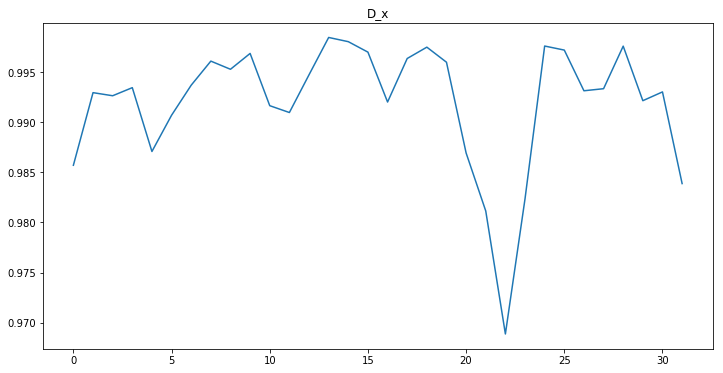

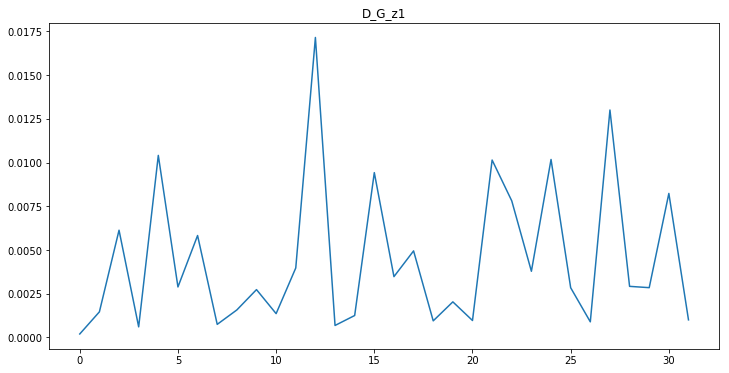

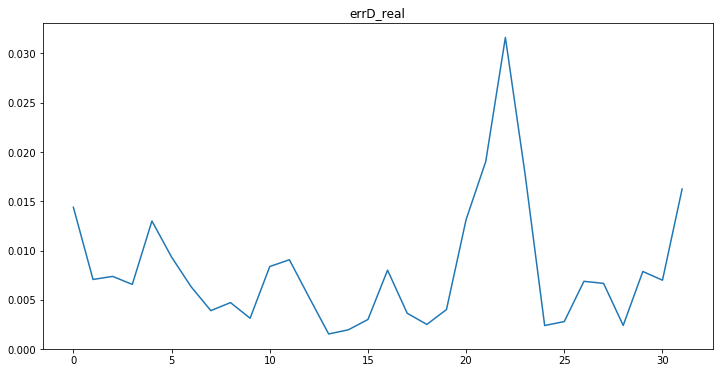

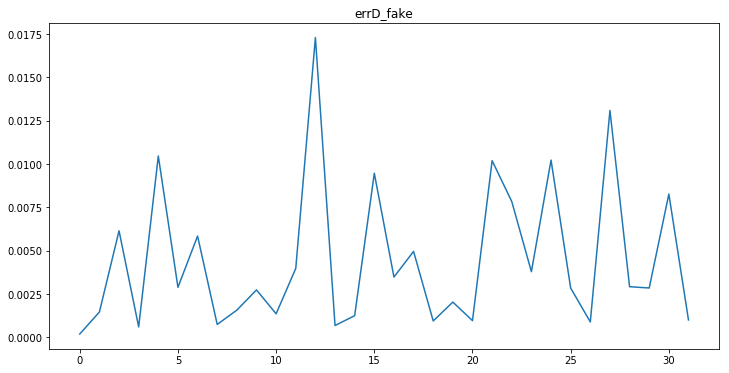

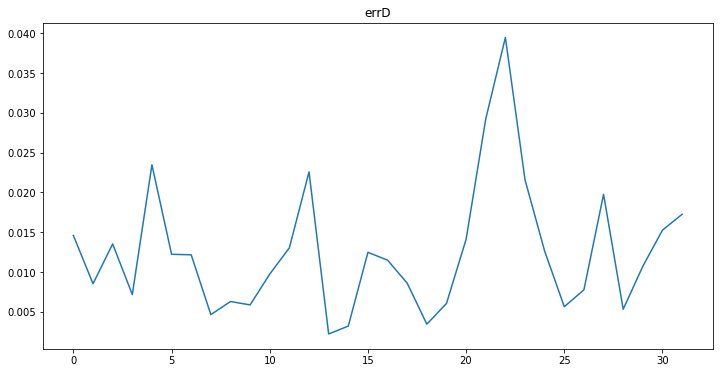

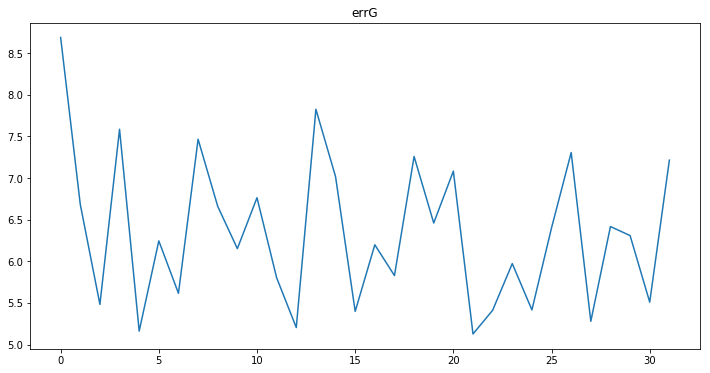

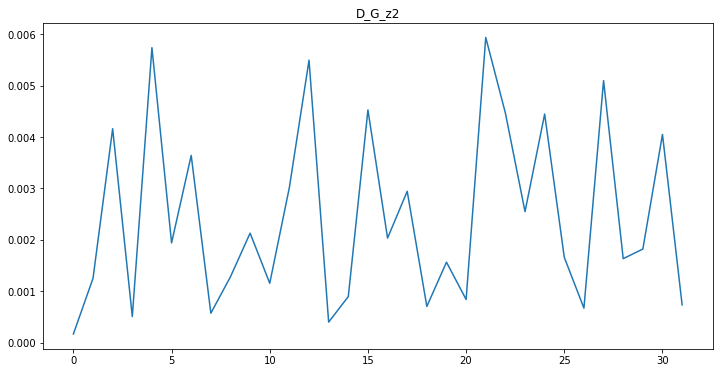

D_x = 0.994769275188446
Forward Propagation of Generator
D_G_z1 = 0.0025403471663594246
errD = errD_real + errD_fake = tensor(0.0078, grad_fn=<ThAddBackward>)
[1/25][0/32] Loss_D: 0.0078 Loss_G: 6.2826 D(x): 0.9948 D(G(z)): 0.0025 / 0.0019
D_x = 0.9913572072982788
Forward Propagation of Generator
D_G_z1 = 0.003631355008110404
errD = errD_real + errD_fake = tensor(0.0123, grad_fn=<ThAddBackward>)
[1/25][1/32] Loss_D: 0.0123 Loss_G: 5.9264 D(x): 0.9914 D(G(z)): 0.0036 / 0.0027
D_x = 0.9954356551170349
Forward Propagation of Generator
D_G_z1 = 0.004560902249068022
errD = errD_real + errD_fake = tensor(0.0091, grad_fn=<ThAddBackward>)
[1/25][2/32] Loss_D: 0.0091 Loss_G: 5.7917 D(x): 0.9954 D(G(z)): 0.0046 / 0.0031
D_x = 0.9914348721504211
Forward Propagation of Generator
D_G_z1 = 0.0032081478275358677
errD = errD_real + errD_fake = tensor(0.0118, grad_fn=<ThAddBackward>)
[1/25][3/32] Loss_D: 0.0118 Loss_G: 6.1008 D(x): 0.9914 D(G(z)): 0.0032 / 0.0022
D_x = 0.9970836043357849
Forward Propag

In [ ]:
D_x_list = []
D_G_z1_list = []
errD_real_list = []
errD_fake_list = []
errD_list = []
errG_list = []
D_G_z2_list = []

#for epoch in range(opt.niter):
for epoch in range(niter):
    
    print("\n --------------------------------------")
    print("Epoch = " +str(epoch) + " / " + str(niter))
    print("-------------------------------------- \n")
    
    if epoch != 0:
        
        plt.figure(figsize=(12,6))
        plt.title("D_x")
        plt.plot(D_x_list)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("D_G_z1")
        plt.plot(D_G_z1_list)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("errD_real")
        plt.plot(errD_real_list)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("errD_fake")
        plt.plot(errD_fake_list)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("errD")
        plt.plot(errD_list)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("errG")
        plt.plot(errG_list)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("D_G_z2")
        plt.plot(D_G_z2_list)
        plt.show()
    
    
    for i, data in enumerate(dataloader, 0):
        
        
#         print("Data Shape = " + str(data.shape))
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        #real_cpu = data[0].to(device)
        real_cpu = data.to(device)
        batch_size = real_cpu.size(0)
#         print("batch_size = " + str(batch_size))
        
        # torch.full -> 
        # Returns a tensor of size size filled with fill_value
        label = torch.full(size = (batch_size,), 
                           fill_value = real_label, 
                           device = device)
#         print("Discriminator real label = " + str(label))

        output = netD(real_cpu)
#         print("Discriminator output shape = " + str(output.shape))
        
        
        errD_real = criterion(output, label)
#         print("Discriminator error (input = real) = " + str(errD_real))
        
        errD_real.backward()
        
        D_x = output.mean().item()
        D_x_list.append(D_x)
        print("D_x = " + str(D_x))

        # train with fake
#         print("batch_size = " + str(batch_size))
#         print("nz = " + str(nz))
        noise = torch.randn(batch_size, 
                            nz, 
                            1, 
                            1,
                            1,
                            device=device)
#         print("Noise shape = " + str(noise.shape))

        
        fake = netG(noise)
#         print("Generator output size = " + str(fake.shape))
    
        # change label from real label (=1) to fake_label (=0)
        label.fill_(fake_label)
        
        output = netD(fake.detach())
        
        # calculate discriminator's error for fake generated input
        errD_fake = criterion(output, label)
#         print("Discriminator error (input = generated by fake noise) = " + \
#               str(errD_fake))
        
        
        errD_fake.backward()
        
        
        D_G_z1 = output.mean().item()
        D_G_z1_list.append(D_G_z1)
        print("D_G_z1 = " + str(D_G_z1))
        
        errD = errD_real + errD_fake
        errD_real_list.append(errD_real)
        errD_fake_list.append(errD_fake)
        errD_list.append(errD)
        print("errD = errD_real + errD_fake = " + str(errD))
        
        
        
        optimizerD.step()

        
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        
        errG = criterion(output, label)
        errG.backward()
        errG_list.append(errG)
        
        D_G_z2 = output.mean().item()
        D_G_z2_list.append(D_G_z2)
        
        optimizerG.step()

        
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        
#         if i % 100 == 0:
#             vutils.save_image(real_cpu,
#                     '%s/real_samples.png' % opt.outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
#                     normalize=True)

    # do checkpointing
#     torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
#     torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))